In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from IPython.display import clear_output
from curve_collapse import find_critical_exponents, scale_variables

In [2]:
lattice_sizes = [20, 30, 40, 50, 60, 70, 80, 100]

Tc = 2/np.log(1 + np.sqrt(2))

J = 1

exec_time_per_site = 10000

temperatures = np.linspace(2, 3, 20)

Tc

2.269185314213022

In [3]:
for L in lattice_sizes:
    for temp in temperatures:
        try:
            filename = f"MC2DIsing_{L}x{L}_T_{temp:.02f}_J_{J:.02f}_texecps_{exec_time_per_site}.txt"
            filedata = np.loadtxt(filename)
            if filedata[-1, 0] != 0:
                continue
        except FileNotFoundError:
            pass
        except IndexError:
            pass
        print(f"L = {L}, temp = {temp}")
        command = f"julia runmc2dising.jl {L} {temp} {J} {exec_time_per_site} -i r".split()
        sp = subprocess.run(command)
        clear_output(wait=True)

Equilibration time plot

Text(0, 0.5, '$M$')

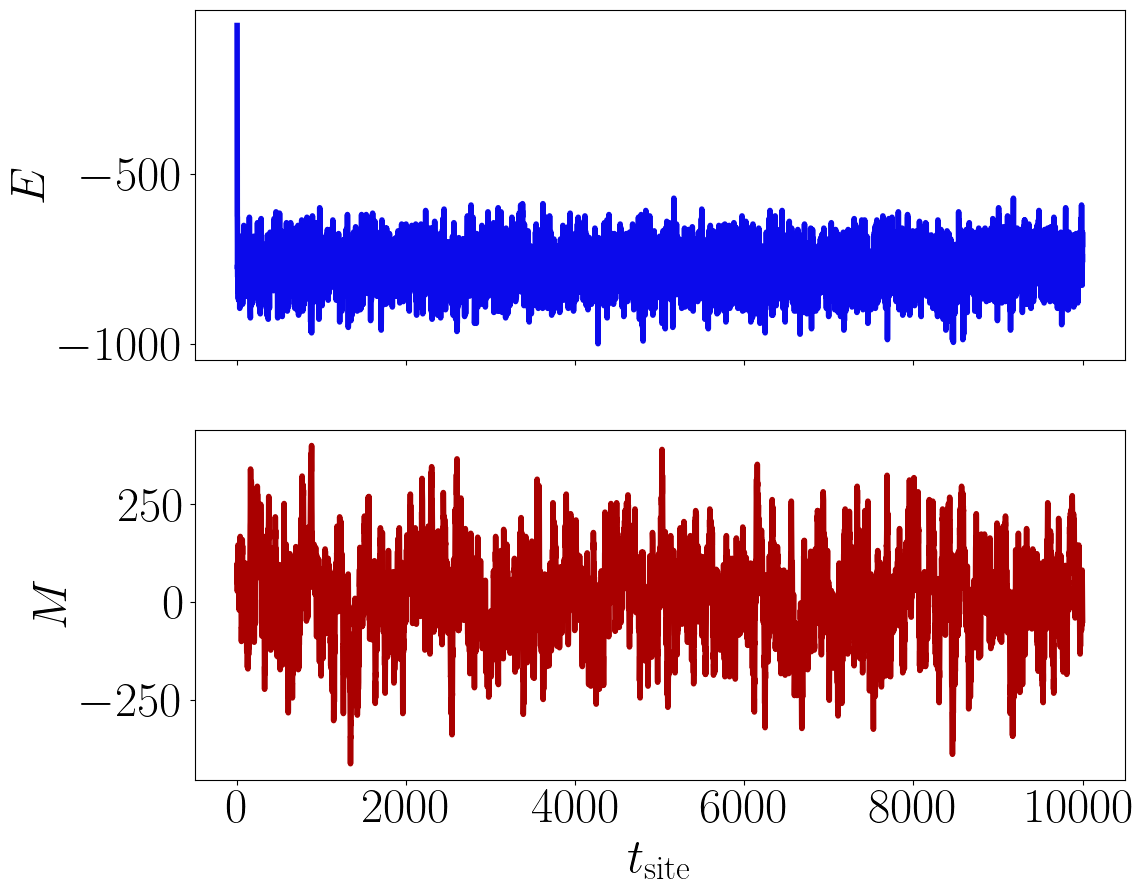

In [4]:
filename = "MC2DIsing_30x30_T_2.89_J_1.00_texecps_10000.txt"

filedata = np.loadtxt(filename)
t_per_site_arr = filedata[:, 0]
energy_arr = filedata[:, 1]
magnetization_arr = filedata[:, 2]

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{physics} \usepackage{mathtools}")
plt.rc("font", family="serif", size=35, weight="bold")
fig, axs = plt.subplots(2, 1, figsize=[12, 10], sharex=True)

axs[0].plot(t_per_site_arr, energy_arr, linewidth=4, color="#0B0AEB")
axs[1].plot(t_per_site_arr, magnetization_arr, linewidth=4, color="#A90000")

axs[1].set_xlabel(r"$t_{\mathrm{site}}$")
axs[0].set_ylabel(r"$E$")
axs[1].set_ylabel(r"$M$")

In [5]:
# Generate a file containing the results from all the simulations performed
# This file contains one row per simulation with the following columns:
# [L, temp, <e>, <e² - <e>²>, <m>, <m² - <m>²>]

filename_summary = f"simulations_sumary.txt"

equilibration_time_per_site = 2000

results = np.zeros((len(lattice_sizes)*len(temperatures), 6))

for Li, L in enumerate(lattice_sizes):
    for Ti, temp in enumerate(temperatures):
        filename = f"MC2DIsing_{L}x{L}_T_{temp:.02f}_J_{J:.02f}_texecps_{exec_time_per_site}.txt"
        filedata = np.loadtxt(filename)
        t_ps_arr = filedata[:, 0]
        e_arr = filedata[:, 1] / L**2
        m_arr = filedata[:, 2] / L**2

        eqt_mask = np.greater_equal(t_ps_arr, equilibration_time_per_site)
        me_arr = e_arr[eqt_mask]
        mm_arr = np.abs(m_arr[eqt_mask])

        e_mean = np.mean(me_arr)
        e_std2 = np.mean(me_arr**2 - e_mean**2)
        m_mean = np.mean(mm_arr)
        m_std2 = np.mean(mm_arr**2 - m_mean**2)

        results_index = len(temperatures)*Li + Ti
        results[results_index, 0] = L
        results[results_index, 1] = temp
        results[results_index, 2] = e_mean
        results[results_index, 3] = e_std2
        results[results_index, 4] = m_mean
        results[results_index, 5] = m_std2

np.savetxt(filename_summary, results)

Perform the finite size scaling

Magnetization

In [6]:
summary_data = np.loadtxt(filename_summary)
summary_lattice_sizes, inds = np.unique(summary_data[:, 0], return_index=True)
summary_lattice_sizes = summary_lattice_sizes.astype(int)[1:]
summary_temp_amount = inds[1]

x = np.zeros((len(summary_lattice_sizes), summary_temp_amount))
y = np.zeros((len(summary_lattice_sizes), summary_temp_amount))
dy = np.zeros((len(summary_lattice_sizes), summary_temp_amount))

for Li, L in enumerate(summary_lattice_sizes):
    row_initial_index = Li*summary_temp_amount
    row_final_index = (Li+1)*summary_temp_amount
    x[Li, :] = summary_data[row_initial_index:row_final_index, 1]
    y[Li, :] = summary_data[row_initial_index:row_final_index, 4]
    dy[Li, :] = summary_data[row_initial_index:row_final_index, 5]

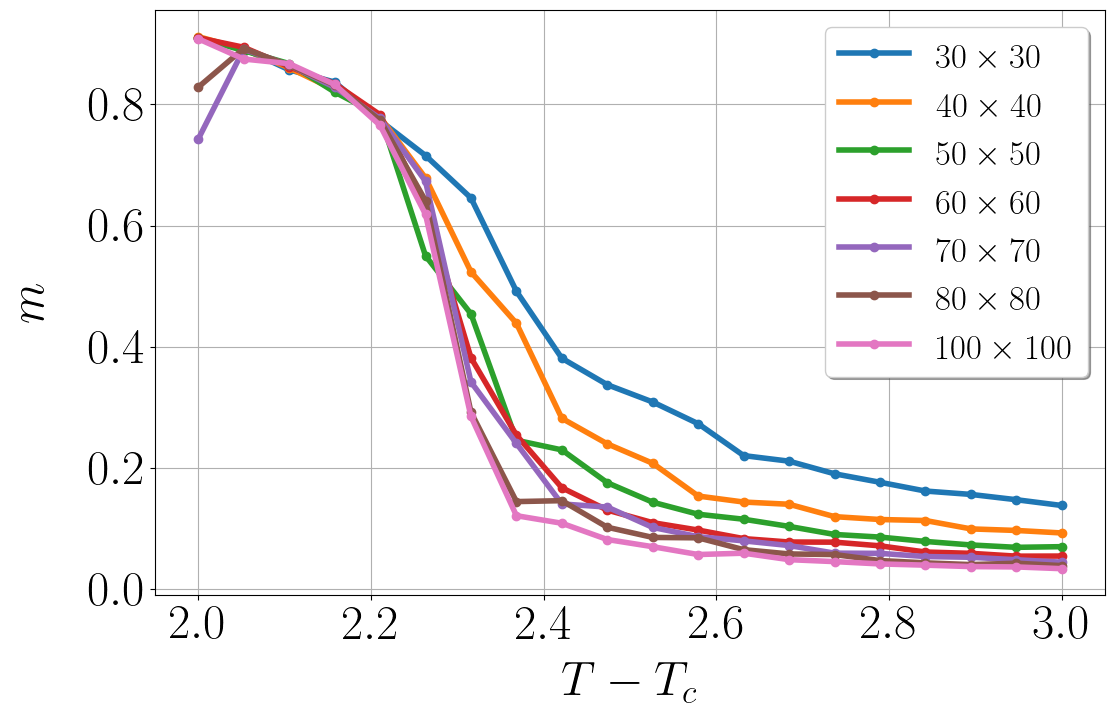

In [7]:
labels = [f"${i}\\times{i}$" for i in summary_lattice_sizes]

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{physics} \usepackage{mathtools}")
plt.rc("font", family="serif", size=35, weight="bold")
fig = plt.figure(figsize=[12, 8])

for i, (size, label) in enumerate(zip(summary_lattice_sizes, labels)):
    this_temp_arr = x[i, :]
    red_temp_ar = this_temp_arr
    this_mag_arr = y[i, :]
    plt.plot(red_temp_ar, this_mag_arr, "o-", linewidth=4, label=label)

plt.grid()
plt.xlabel(r"$T - T_c$", labelpad=10)
plt.ylabel(r"$m$", labelpad=25)
plt.legend(shadow=True, fontsize=25)
plt.tight_layout()
plt.savefig("magnetization.png", dpi=300)

In [18]:
# Get scaling parameters
# Use as inital guess the critical exponents for the 3D classical Ising model
xbounds = None #[2.1, 2.4]
ftol = 1e-5

mindy = 1e-9
dy = np.maximum(dy, mindy)

T0= 2*J/np.log(1 + np.sqrt(2))
etaexp0 = 1/8 # -beta
nuexp0 = 1

sx, sy, sdy = scale_variables(x, y, dy, summary_lattice_sizes, T0, etaexp0, nuexp0)

print("\rFinding critical parameters...")
cparams, cparams_err = find_critical_exponents(x, y, dy, summary_lattice_sizes, T0, etaexp0, nuexp0, xbounds=xbounds, ftol=ftol)
print(f"λ_c = {cparams[0]} ± {cparams_err[0]}")
print(f"ζ_c = {cparams[1]} ± {cparams_err[1]}")
print(f"ν_c = {cparams[2]} ± {cparams_err[2]}")

Finding critical parameters...
λ_c = 2.267585086427793 ± 0.0031622776601683794
ζ_c = -0.10438390624569599 ± 0.0031622776601683794
ν_c = 0.7815818735429738 ± 0.0031622776601683794


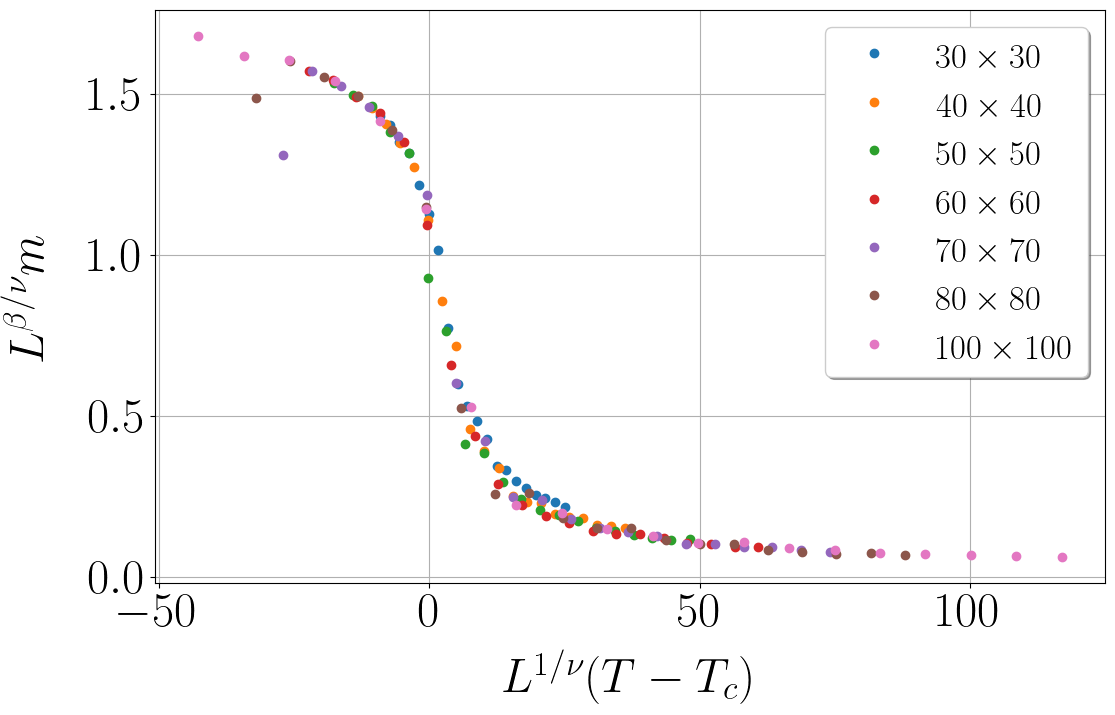

In [19]:
labels = [f"${i}\\times{i}$" for i in summary_lattice_sizes]

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{physics} \usepackage{mathtools}")
plt.rc("font", family="serif", size=35, weight="bold")
fig = plt.figure(figsize=[12, 8])

Tc = cparams[0]
betaexp = -cparams[1]
nuexp = cparams[2]

for i, (size, label) in enumerate(zip(summary_lattice_sizes, labels)):
    this_temp_arr = x[i, :]
    red_temp_arr = (this_temp_arr - Tc)/Tc
    this_mag_arr = y[i, :]
    xplot = size**(1/nuexp)*red_temp_arr
    yplot = size**(betaexp/nuexp)*this_mag_arr
    plt.plot(xplot, yplot, "o", linewidth=4, label=label)

plt.grid()
plt.xlabel(r"$L^{1/\nu} (T - T_c)$", labelpad=10)
plt.ylabel(r"$L^{\beta/\nu}m$", labelpad=25)
plt.legend(shadow=True, fontsize=25)
plt.tight_layout()
plt.savefig("magnetization_auto_scaling.png", dpi=300)

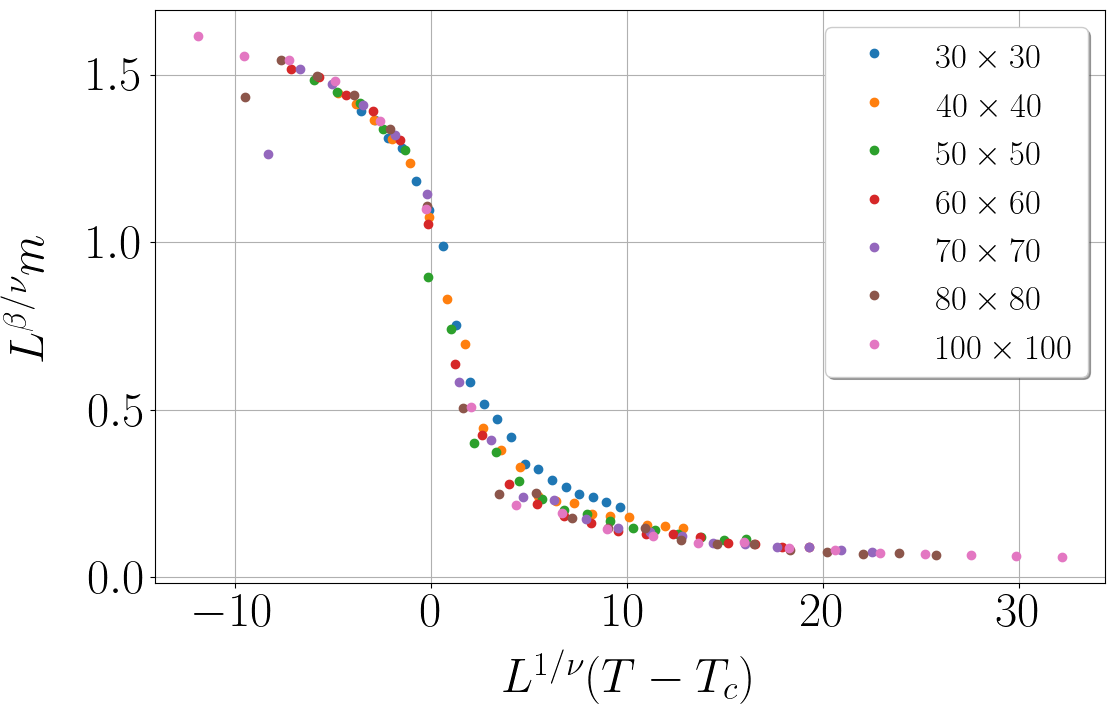

In [10]:
labels = [f"${i}\\times{i}$" for i in summary_lattice_sizes]

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{physics} \usepackage{mathtools}")
plt.rc("font", family="serif", size=35, weight="bold")
fig = plt.figure(figsize=[12, 8])

Tc = T0#cparams[0]
betaexp = 1/8#-cparams[1]
nuexp = 1#cparams[2]

for i, (size, label) in enumerate(zip(summary_lattice_sizes, labels)):
    this_temp_arr = x[i, :]
    red_temp_arr = (this_temp_arr - Tc)/Tc
    this_mag_arr = y[i, :]
    xplot = size**(1/nuexp)*red_temp_arr
    yplot = size**(betaexp/nuexp)*this_mag_arr
    plt.plot(xplot, yplot, "o", linewidth=4, label=label)

plt.grid()
plt.xlabel(r"$L^{1/\nu} (T - T_c)$", labelpad=10)
plt.ylabel(r"$L^{\beta/\nu}m$", labelpad=25)
plt.legend(shadow=True, fontsize=25)
plt.tight_layout()
plt.savefig("magnetization_scaling_good.png", dpi=300)

Fidelity susceptibility